# Using k-means clustering to discover discrepancies between the two counter-circulating beams of the Large Hadron Collider

4 kinds of analysis (k-means clustering, Euclidean distance, DBSCAN, Linear classifier) x 2 kinds of data (PCA, not PCA) x 4 beam modes (flat_top, start_ramp, start_adjust, start_squeeze)

In [4]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.cluster import KMeans

## Load data


This data must be available before running this notebook.  Run the `Data collection.ipynb` notebook to create the data if it does not exist.

In [10]:
# Read saved ('pickled') DataFrames (result of Data collection notebook)
startRampLosses = pd.read_pickle("data/pickles/startRampLosses.pkl")
startAdjustLosses = pd.read_pickle("data/pickles/startAdjustLosses.pkl")
startSqueezeLosses = pd.read_pickle("data/pickles/startSqueezeLosses.pkl")
flatTopLosses = pd.read_pickle("data/pickles/flatTopLosses.pkl")

#TODO - maybe have just one losses variable, and read_pickle the different loss files manually (parameterising the notebook)

## Preprocessing

### Check variances, range

In [8]:
losses = flatTopLosses;  # change to any one of the other losses to compare (startRampLosses, startAdjustLosses, ...)

print("Std deviation\n")
print(losses.std().sort_values().head(1))
print(losses.std().sort_values().tail(1))
print("\nRange\n")
print((losses.max() - startRampLosses.min()).sort_values().head(1))
print((losses.max() - startRampLosses.min()).sort_values().tail(1))

Std deviation

TCDSB.4x6    1.00166
dtype: float64
TCL.6x5    1.00166
dtype: float64

Range

TCTPV.4x2    1.891248
dtype: float64
TCSP.A4x6_2    16.602021
dtype: float64


There is a large difference in order of magnitude in variance and range between the BLMs.  So that BLMs with high variance do not dominate the clustering and PCA calculations, we must standardise the values.

### Standardise data

According to https://maxwellsci.com/msproof.php?doi=rjaset.6.3638 standardisation is the most effective scaling technique before k-means.

TODO compare clustering efficiency with robustscaler, min-max scaler

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

startRampLosses.loc[:] = scaler.fit_transform(startRampLosses.loc[:])
startSqueezeLosses.loc[:] = scaler.fit_transform(startSqueezeLosses.loc[:])
startAdjustLosses.loc[:] = scaler.fit_transform(startAdjustLosses.loc[:])
flatTopLosses.loc[:] = scaler.fit_transform(flatTopLosses.loc[:])

### Dimensionality reduction using PCA

In [12]:
from sklearn.decomposition import PCA

# pca = PCA()  # n_components not set => keep all components
# print('Explained variance ratio of each BLM (sums to 1):')
# pca.fit(startRampLosses)
#TODO print the BLM names too - i.e. startRampLosses.columns (maybe make a quick dataframe to illustrate)
# print(pca.explained_variance_ratio_)
# print(sum(pca.explained_variance_ratio_))

pca = PCA(n_components=3)
startRampLossesPCA = pd.DataFrame(data=pca.fit_transform(startRampLosses), index=startRampLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
startSqueezeLossesPCA = pd.DataFrame(data=pca.fit_transform(startSqueezeLosses), index=startSqueezeLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
startAdjustLossesPCA = pd.DataFrame(data=pca.fit_transform(startAdjustLosses), index=startAdjustLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
flatTopLossesPCA = pd.DataFrame(data=pca.fit_transform(flatTopLosses), index=flatTopLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])

## Visualising the 3D PCA data

Helper function

In [114]:
def scatterPlotLosses(losses, title="", ax=None):
    noExistingAxes = (ax == None)

    if noExistingAxes:
        %matplotlib notebook
        from mpl_toolkits.mplot3d import Axes3D
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    xs = losses.loc['B1'][losses.columns[0]]
    ys = losses.loc['B1'][losses.columns[1]]
    zs = losses.loc['B1'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c='red', label='B1')

    xs = losses.loc['B2'][losses.columns[0]]
    ys = losses.loc['B2'][losses.columns[1]]
    zs = losses.loc['B2'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c='black', label='B2')

    ax.set_title(title)
    ax.set_xlabel(losses.columns[0])
    ax.set_ylabel(losses.columns[1])
    ax.set_zlabel(losses.columns[2])
    
    if noExistingAxes:
        plt.legend()
        plt.show()

Plotting

come on
what


<IPython.core.display.Javascript object>


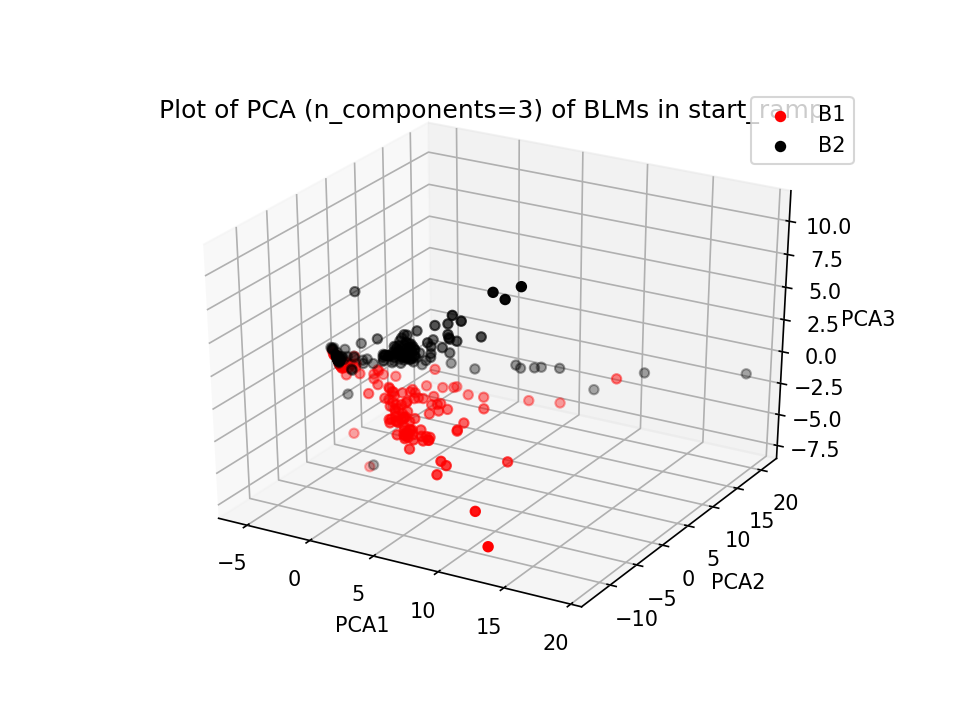

In [99]:
scatterPlotLosses(startRampLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_ramp")

<IPython.core.display.Javascript object>


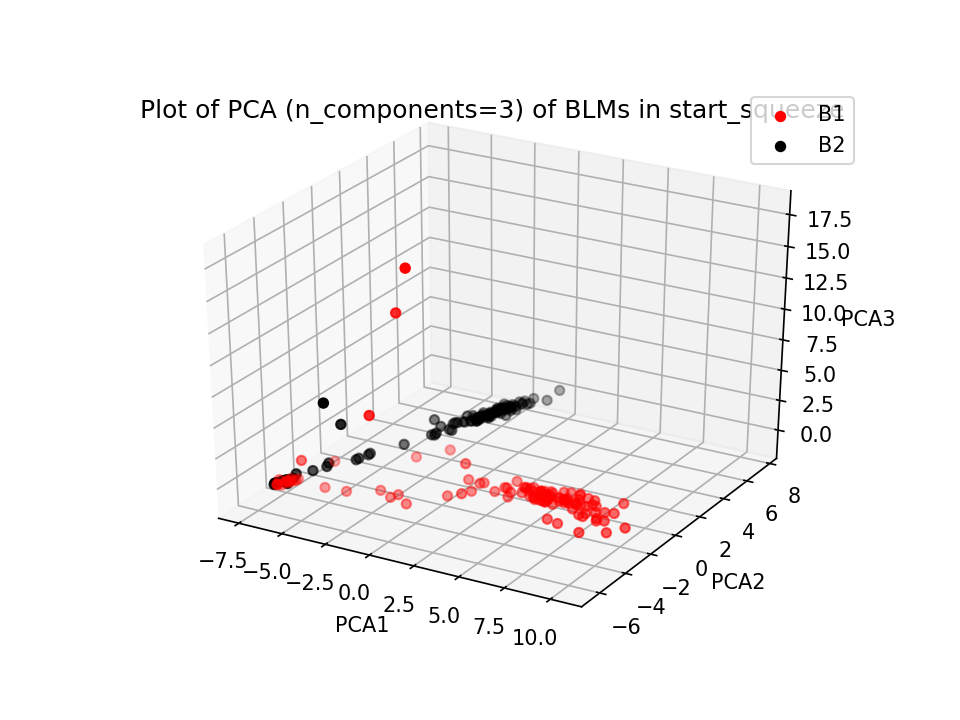

In [86]:
scatterPlotLosses(startSqueezeLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_squeeze")

<IPython.core.display.Javascript object>


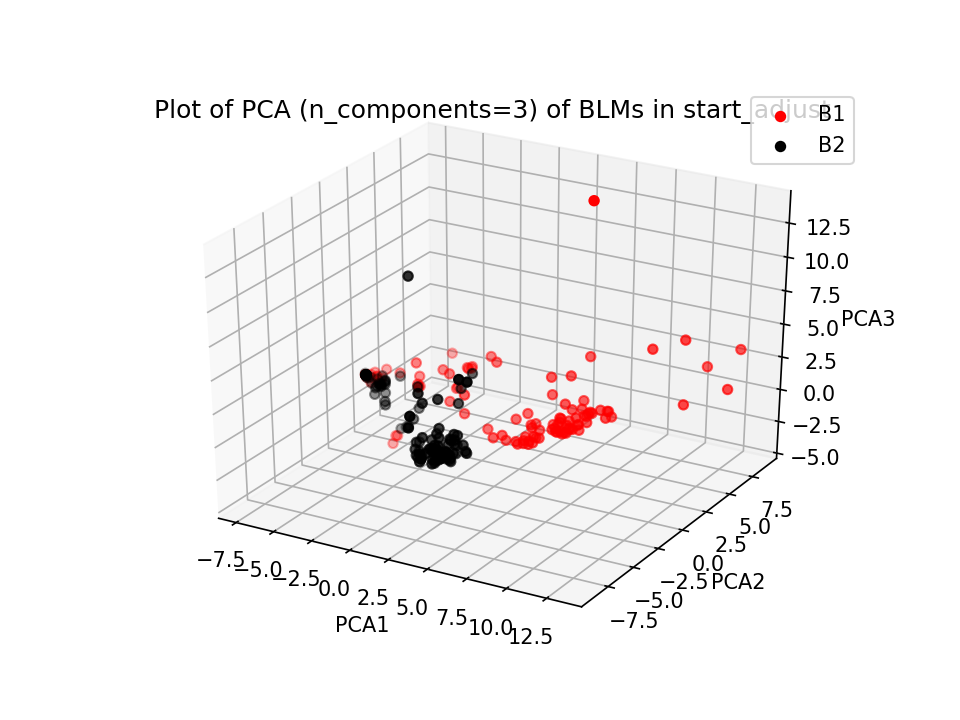

In [115]:
scatterPlotLosses(startAdjustLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_adjust")

<IPython.core.display.Javascript object>


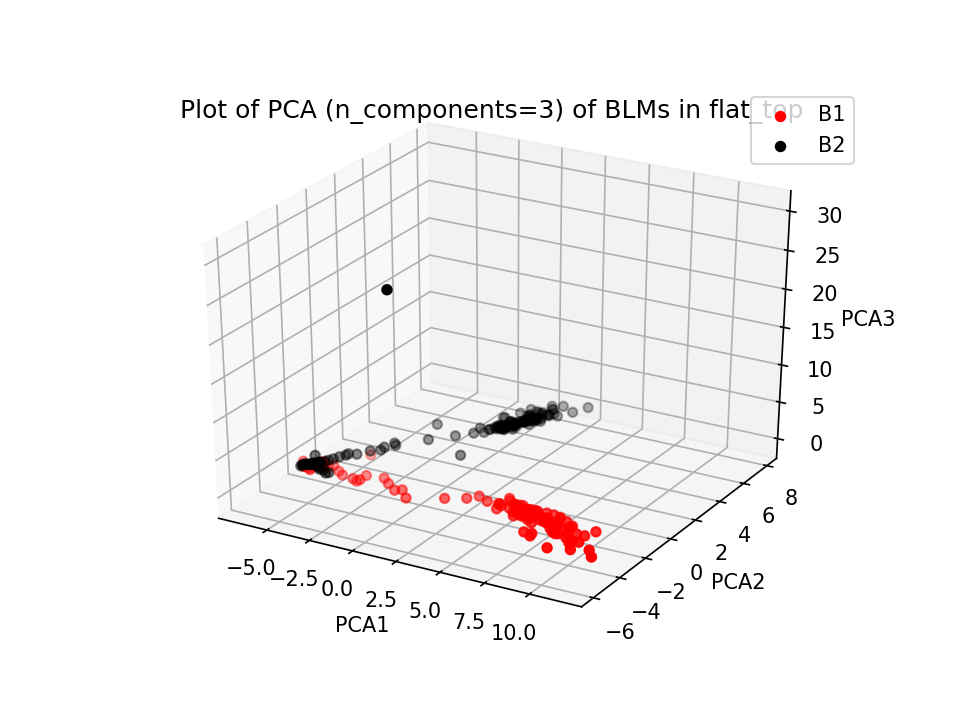

In [116]:
scatterPlotLosses(flatTopLossesPCA, "Plot of PCA (n_components=3) of BLMs in flat_top")

## KMeans clustering

### Helper function

In [141]:
def compareKMeansWithGroundTruth(labels, losses):
    for clusterNo in range(0, 2):  # loop through cluster 0, 1
        b1Count = 0
        b2Count = 0
        indicesOfLossesInCluster = np.where(labels == clusterNo)[0]
        lossesInClusterCount = len(indicesOfLossesInCluster)
        
        for key in losses.index.values[indicesOfLossesInCluster]:
            if key[0] == 'B1':
                b1Count = b1Count + 1
            elif key[0] == 'B2':
                b2Count = b2Count + 1
            else:
                print("Key error - neither B1 nor B2 in key {}".format(key))
                
        assert b1Count + b2Count == lossesInClusterCount
        
        if b1Count <= b2Count:
            print(f'\tCluster {clusterNo} is {(b2Count / lossesInClusterCount):%} B2 losses') # :.2% to set dec places
        elif b1Count > b2Count:
            print(f'\tCluster {clusterNo} is {(b1Count / lossesInClusterCount):%} B1 losses')

In [148]:
def kmeansAnalysis(kmeans, losses, lossesPCA, phaseName):
    print(f"{phaseName}\n")
    
    print('\tFull feature-space')
    labels = kmeans.fit_predict(losses)
    compareKMeansWithGroundTruth(labels, losses)
    print('\n\tPCA')
    labelsPCA = kmeans.fit_predict(lossesPCA)
    compareKMeansWithGroundTruth(labelsPCA, lossesPCA)
    
    scatterPlotClusters2(lossesPCA, f"k-means clusters of {phaseName} - PCA", labelsPCA)

### Analysis

In [143]:
kmeans = KMeans(n_clusters = 2)

flat_top

	Full feature-space
	Cluster 0 is 98.901099% B1 losses
	Cluster 1 is 71.090047% B2 losses

	PCA
	Cluster 0 is 98.901099% B1 losses
	Cluster 1 is 71.090047% B2 losses


<IPython.core.display.Javascript object>


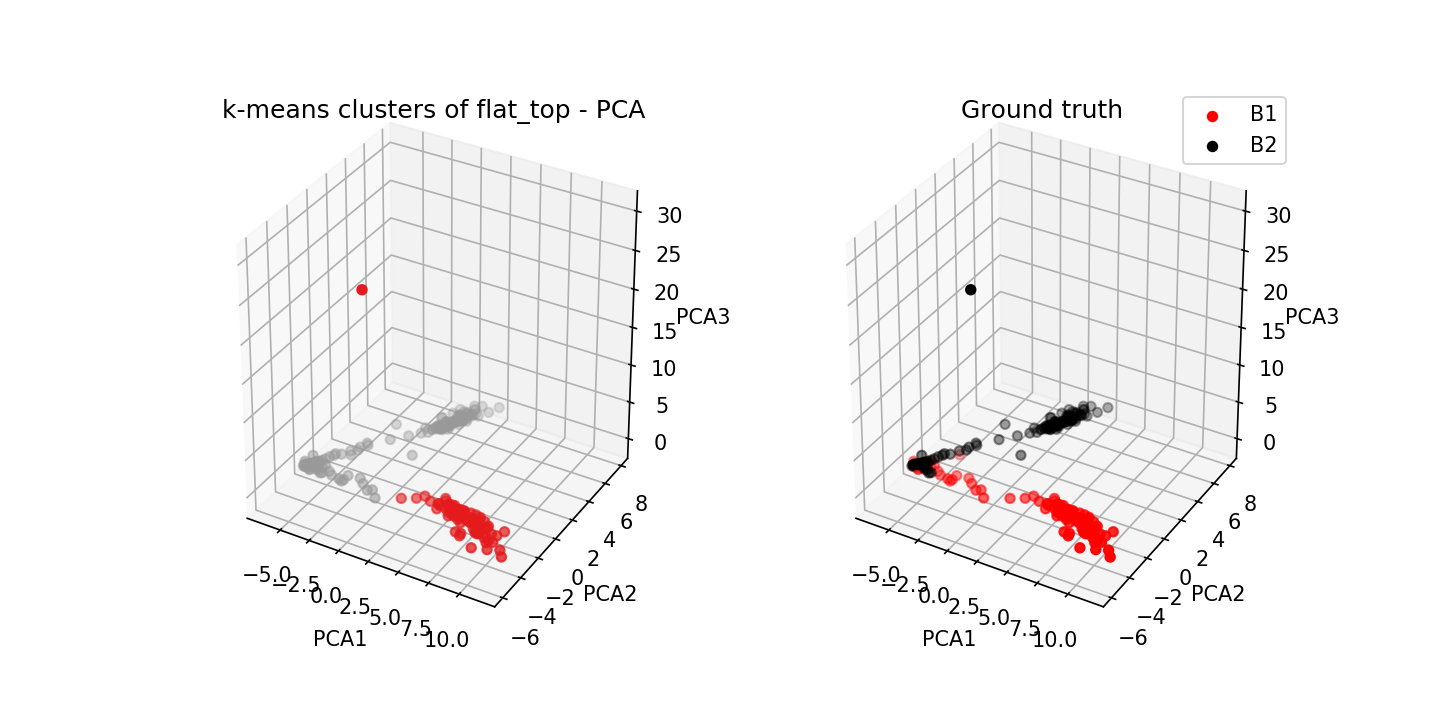

In [157]:
kmeansAnalysis(kmeans, flatTopLosses, flatTopLossesPCA, "flat_top")

start_ramp

	Full feature-space
	Cluster 0 is 50.574713% B1 losses
	Cluster 1 is 50.781250% B2 losses

	PCA
	Cluster 0 is 50.581395% B1 losses
	Cluster 1 is 50.769231% B2 losses


<IPython.core.display.Javascript object>


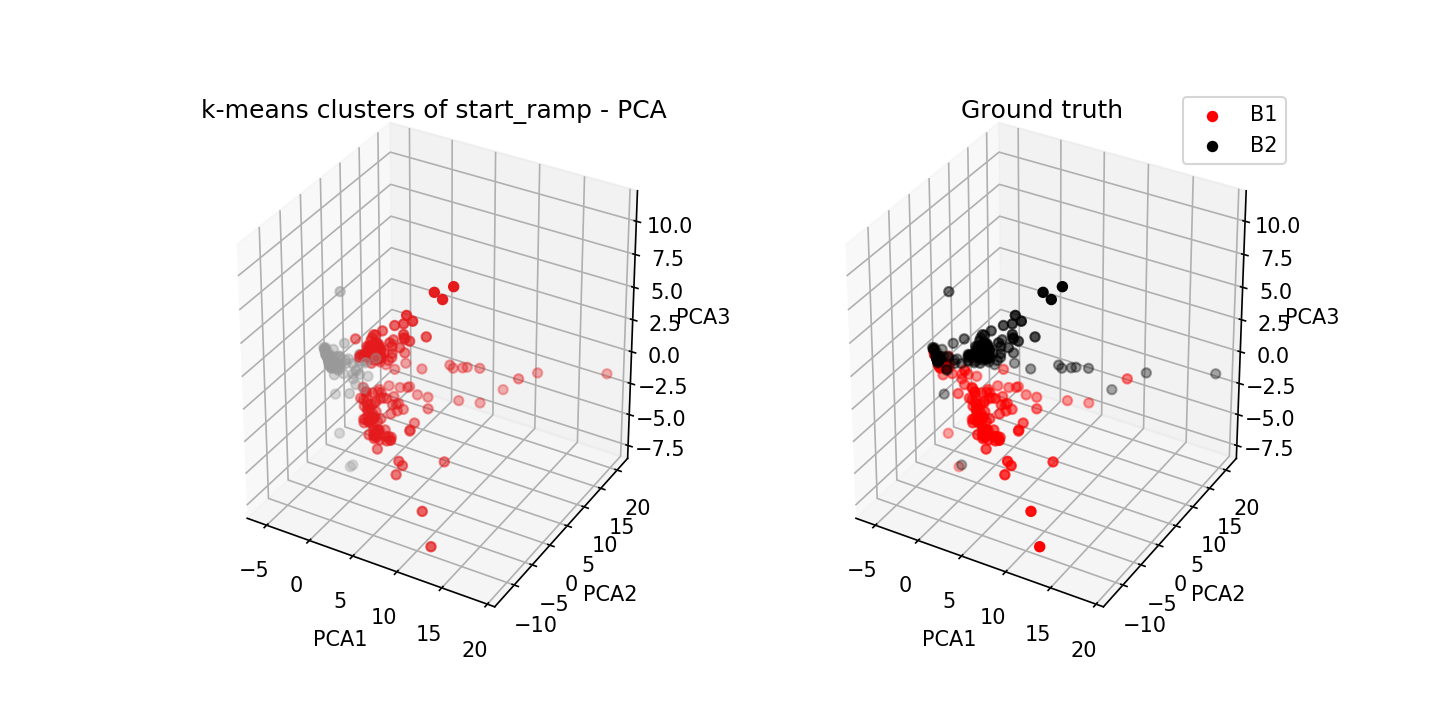

In [158]:
kmeansAnalysis(kmeans, startRampLosses, startRampLossesPCA, "start_ramp")

start_squeeze

	Full feature-space
	Cluster 0 is 100.000000% B1 losses
	Cluster 1 is 79.310345% B2 losses

	PCA
	Cluster 0 is 100.000000% B1 losses
	Cluster 1 is 79.310345% B2 losses


<IPython.core.display.Javascript object>


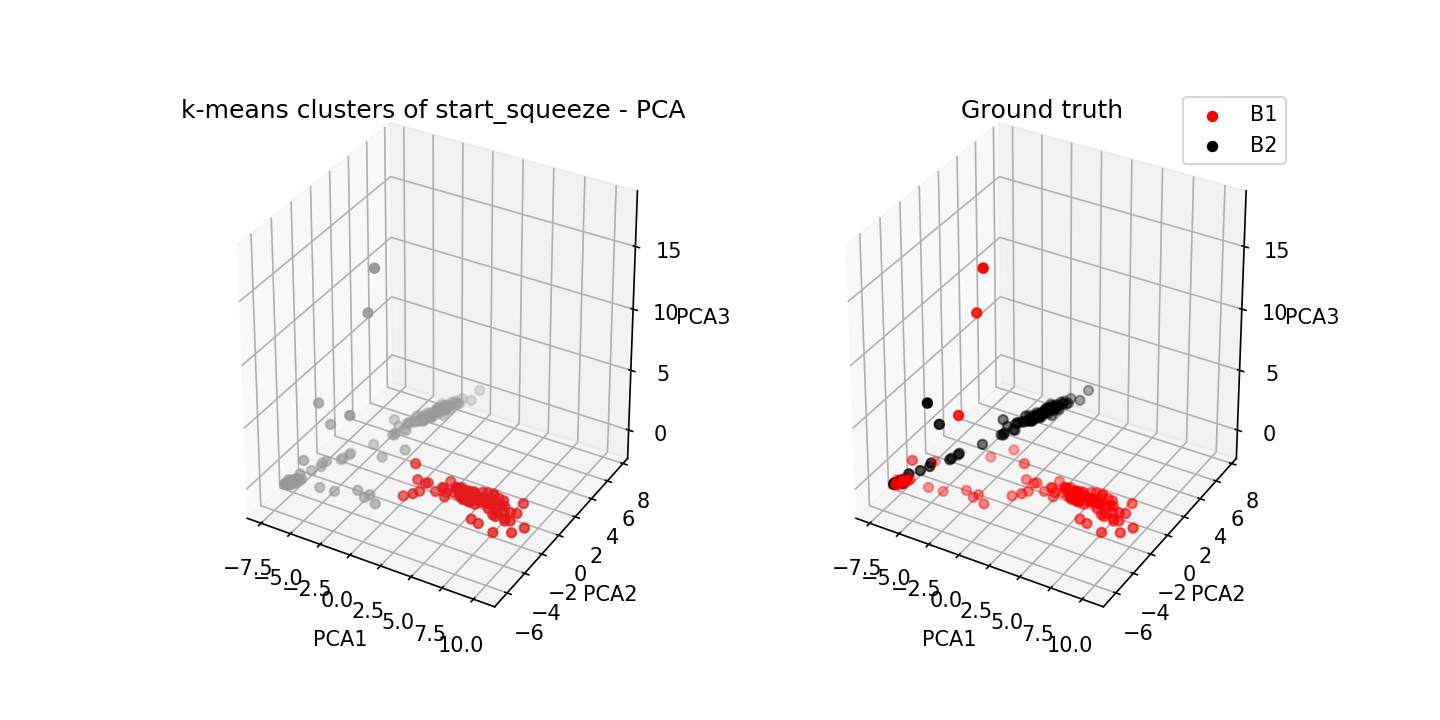

In [159]:
kmeansAnalysis(kmeans, startSqueezeLosses, startSqueezeLossesPCA, "start_squeeze")

start_adjust

	Full feature-space
	Cluster 0 is 50.704225% B1 losses
	Cluster 1 is 51.020408% B2 losses

	PCA
	Cluster 0 is 50.704225% B1 losses
	Cluster 1 is 51.020408% B2 losses


<IPython.core.display.Javascript object>


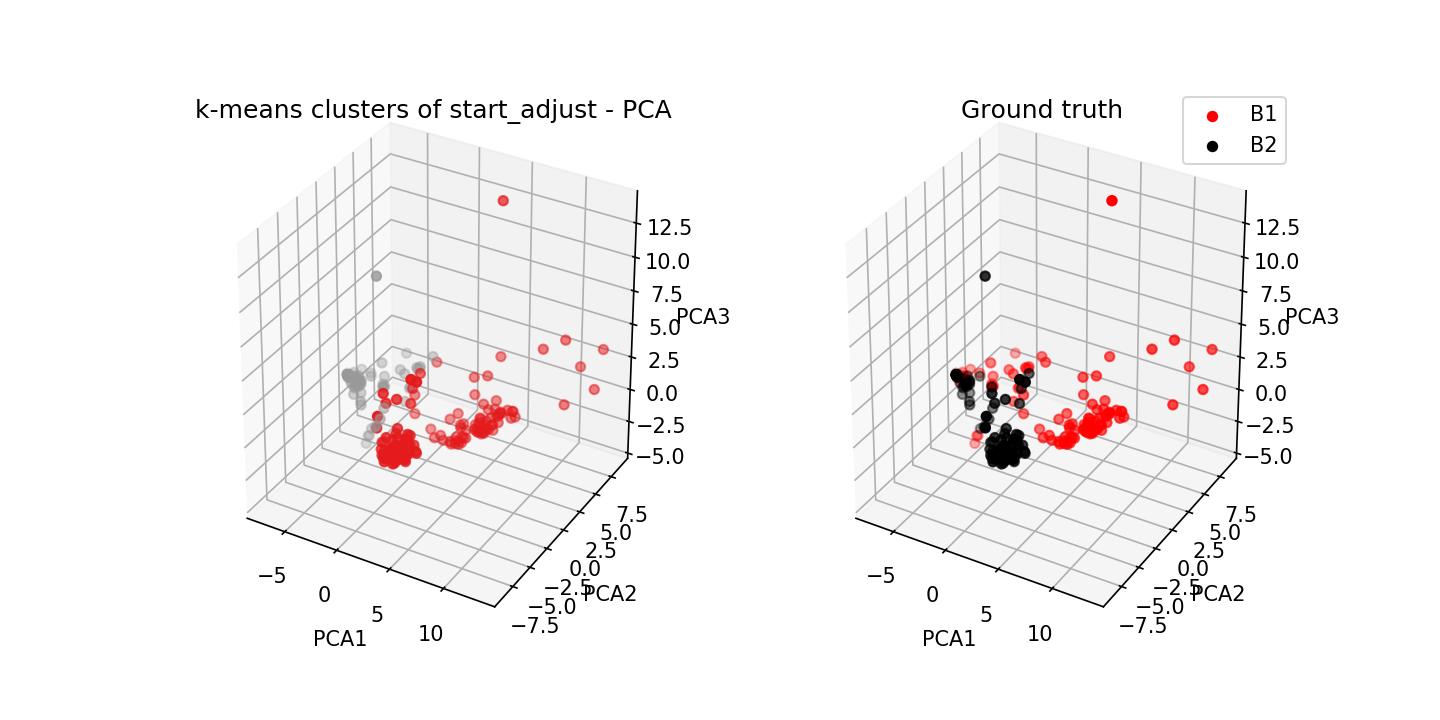

In [160]:
kmeansAnalysis(kmeans, startAdjustLosses, startAdjustLossesPCA, "start_adjust")

**Plotting**

In [49]:
def scatterPlotClusters(losses, title="", labels=None):
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D
    
    assert len(losses) == len(labels)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # marker indicates ground truth, colour indicates cluster
    # TODO create proper legend for ground truth
    xs = losses.loc['B1'][losses.columns[0]]
    ys = losses.loc['B1'][losses.columns[1]]
    zs = losses.loc['B1'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c=labels[: len(labels)//2], cmap='Set1', marker='o')

    xs = losses.loc['B2'][losses.columns[0]]
    ys = losses.loc['B2'][losses.columns[1]]
    zs = losses.loc['B2'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c=labels[len(labels)//2 :], cmap='Set1', marker='^')
    
    ax.set_xlabel(losses.columns[0])
    ax.set_ylabel(losses.columns[1])
    ax.set_zlabel(losses.columns[2])
    plt.title(title)
    plt.show()

In [154]:
def scatterPlotClusters2(losses, title="", labels=None):
    #TODO decide between scatterPlotClusters or scatterPlotClusters2 - I think method 2 is neater
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D
    
    assert len(losses) == len(labels)

    fig = plt.figure(figsize=plt.figaspect(0.5))  # make the figure half as tall as it is wide
    
    # Clusters subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title(title)
    ax.scatter(losses[losses.columns[0]], losses[losses.columns[1]], losses[losses.columns[2]],
               c=labels, cmap='Set1')
    ax.set_xlabel(losses.columns[0])
    ax.set_ylabel(losses.columns[1])
    ax.set_zlabel(losses.columns[2])
    
    # Ground truth subplot
    scatterPlotLosses(losses, "Ground truth", fig.add_subplot(1, 2, 2, projection='3d'))
    
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


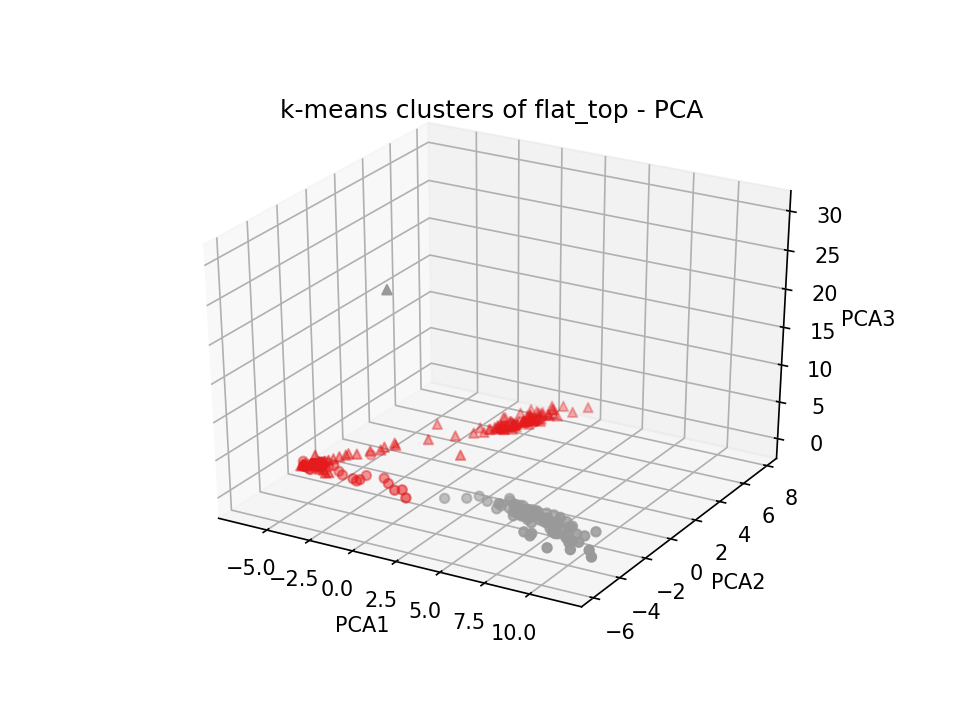

In [155]:
scatterPlotClusters(flatTopLossesPCA, "k-means clusters of flat_top - PCA", labels)

<IPython.core.display.Javascript object>


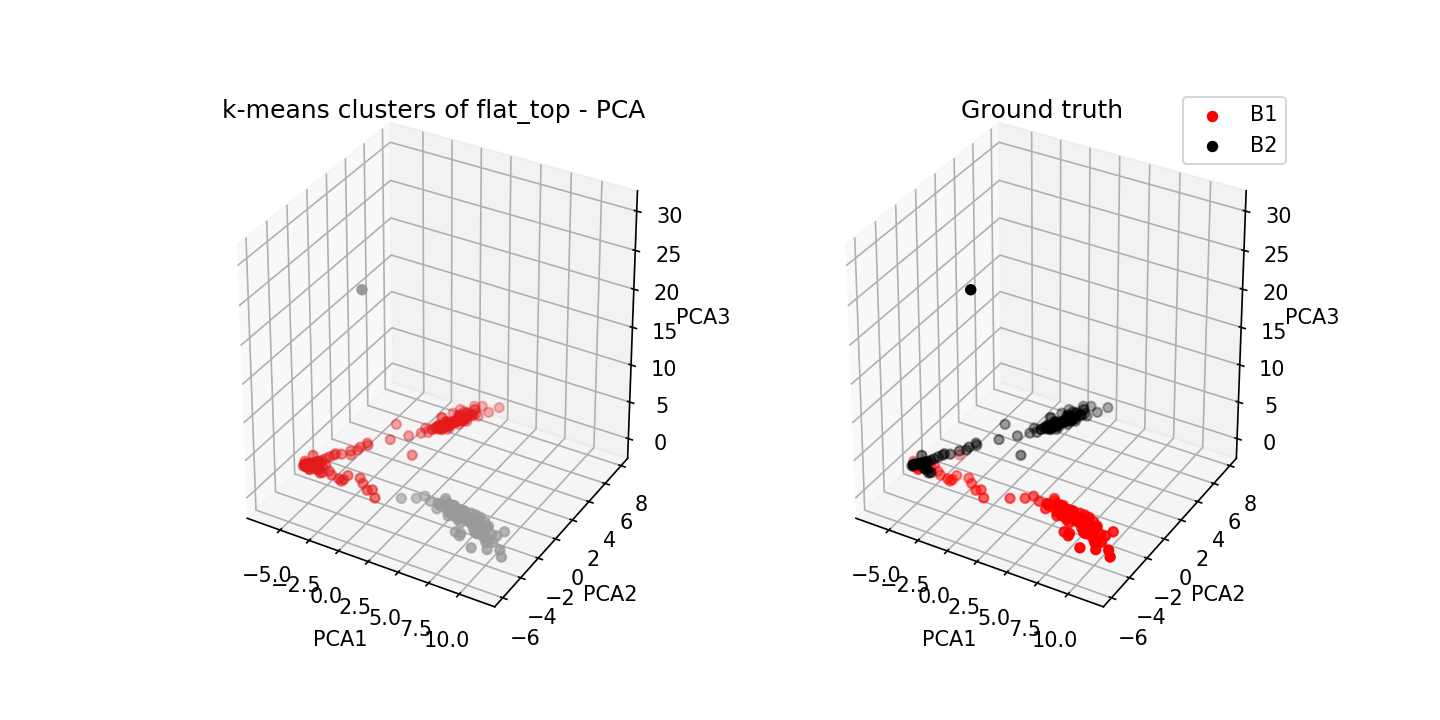

In [156]:
scatterPlotClusters2(flatTopLossesPCA, "k-means clusters of flat_top - PCA", labels)

## DBSCAN



In [52]:
from sklearn.cluster import DBSCAN
# eps - "The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not
#        a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose 
#        appropriately for your data set and distance function."
# min_samples - "The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
#                This includes the point itself."
# 


dbs = DBSCAN(eps=0.9, min_samples=5)
labels = dbs.fit_predict(startRampLosses)
print("start_ramp Cluster memberships:\n{}".format(dbs.labels_)) # Outliers are assigned to the -1 cluster

start_ramp Cluster memberships:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0
  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0 -1  0  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0
  0 -1  0  0 -1 -1 -1  0  0  0  0  0  0  0  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  2  2  2  2  2  2  2  2  2 -1  2 -1  2  2  2  2  2  2 -1
  2  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  2  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  2 -1 -1  2  2  2 -1  2  2 -1 -1 -1  2  2  2  2  2  2  2 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

<IPython.core.display.Javascript object>


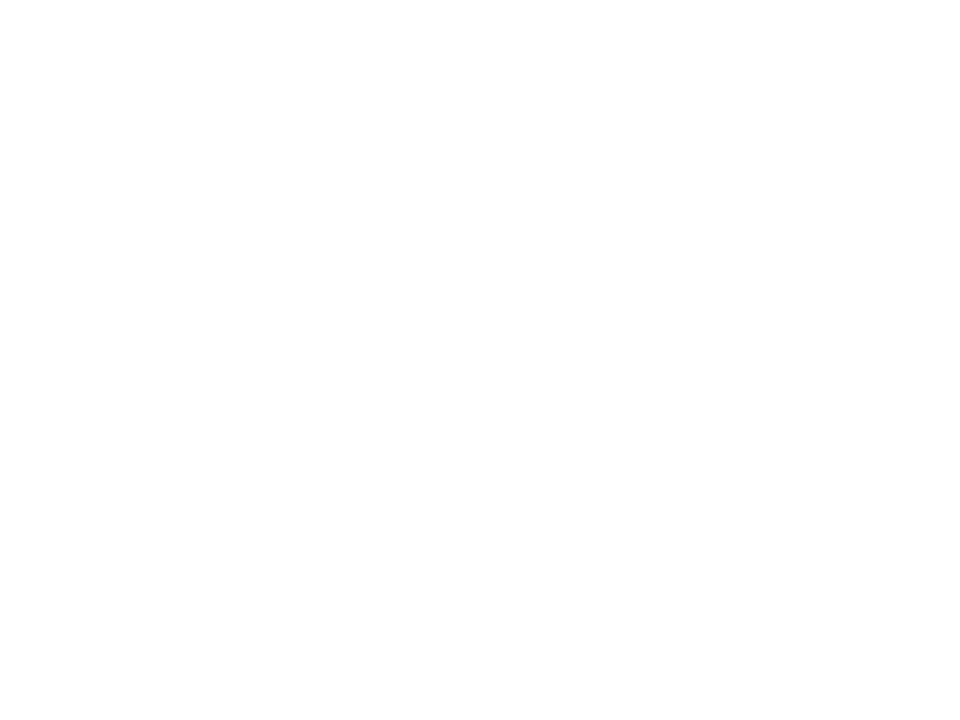

In [8]:
import matplotlib.ticker as plticker

# Data
df = pd.DataFrame({
    'B1': startRampLosses.loc['B1']['TCP.C6x7'],
    'B2': startRampLosses.loc['B2']['TCP.C6x7']
})
 
# multiple line plot
fig, ax = plt.subplots()
ax.plot('B1', data=df, marker='x', color='red')
ax.plot('B2', data=df, marker='x', color='black')
ax.set(xlabel='Fill', ylabel='Loss', title='Plot of the loss registered in TCP.C6x7 against the fill number')
ax.legend()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

<IPython.core.display.Javascript object>


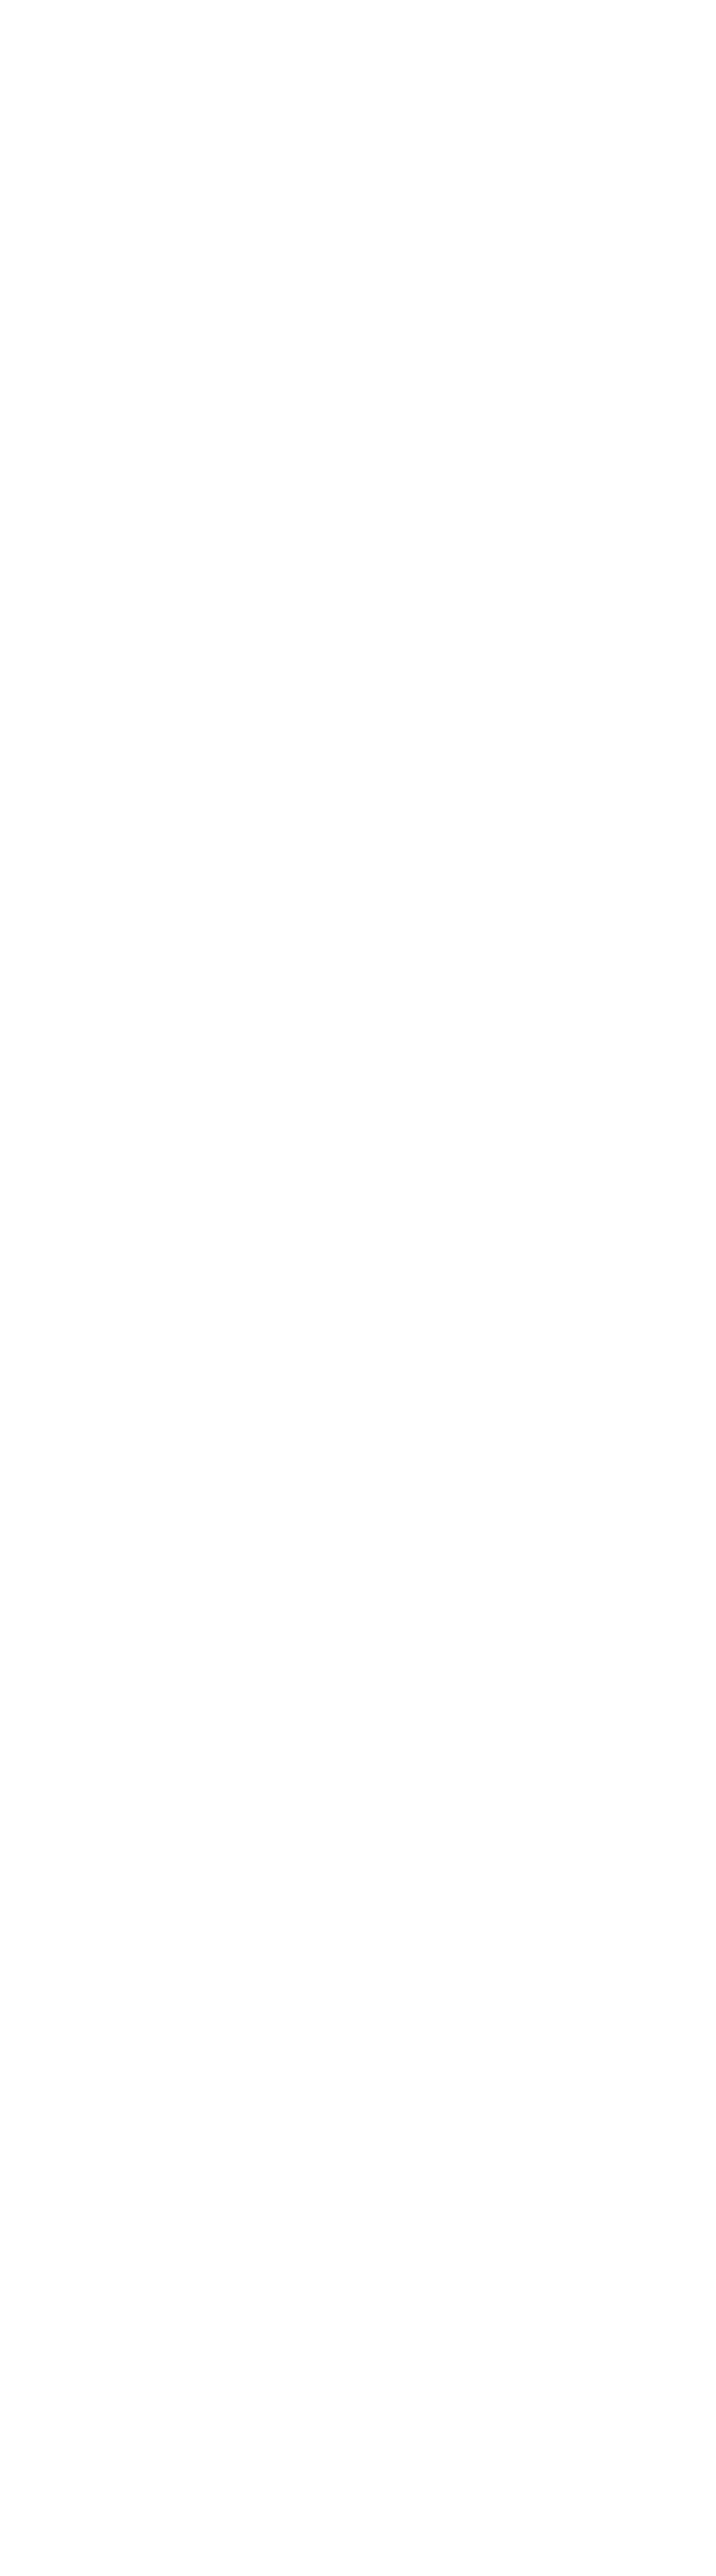

C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


In [9]:
plt.figure(figsize=(10, 36))
ncols = 3;
nrows = math.ceil(startRampLosses.shape[1] / ncols)
i = 1;
for column in startRampLosses:
    # Data
    df = pd.DataFrame({
        'B1': startRampLosses.loc['B1'][column],
        'B2': startRampLosses.loc['B2'][column]
    })
 
    plt.subplot(nrows, ncols, i)
    plt.yscale('log')
    plt.plot('B1', data=df, marker='x', color='red')
    plt.plot('B2', data=df, marker='x', color='black')
    plt.title(column)

    
    i = i + 1
    

plt.tight_layout()

## Euclidean distance

In [10]:
#To get Euclidean distance between the BLM vectors for beam 1 and beam 2
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

startRampDistance = pd.Series(
    cdist(startRampLosses.loc['B1'].values, startRampLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startRampLosses.loc['B1'].index)  # in order to preserve the fill numbers for x-axis of the euclidean distance plot
startAdjustDistance = pd.Series(
    cdist(startAdjustLosses.loc['B1'].values, startAdjustLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startAdjustLosses.loc['B1'].index)
startSqueezeDistance = pd.Series(
    cdist(startSqueezeLosses.loc['B1'].values, startSqueezeLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startSqueezeLosses.loc['B1'].index)
flatTopDistance = pd.Series(
    cdist(flatTopLosses.loc['B1'].values, flatTopLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=flatTopLosses.loc['B1'].index)

#getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
#eg. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
#row 1 of B2 values, and so on.

#to confirm values are correct:
# print(distance)
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[0], mergedPhaseLosses.loc['B2'].iloc[0]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[1], mergedPhaseLosses.loc['B2'].iloc[1]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[2], mergedPhaseLosses.loc['B2'].iloc[2]))


<IPython.core.display.Javascript object>


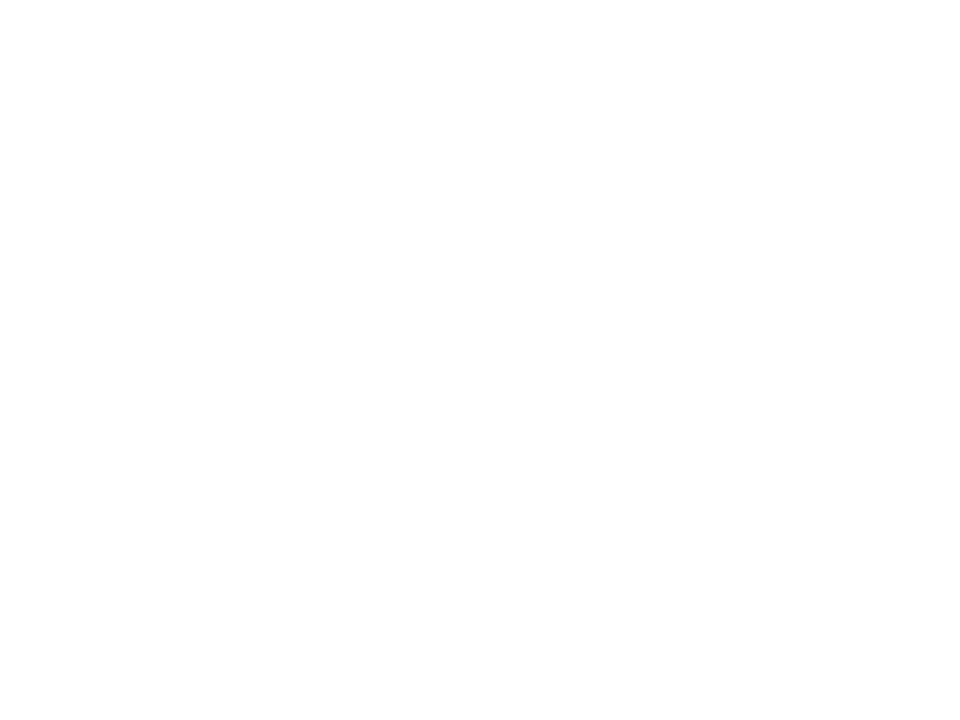

Text(0, 0.5, 'Euclidean distance')

In [11]:
# To plot Euclidean between the vectors (TCP, TCSG, ...) for beam 1 and beam 2
# Data
df = pd.DataFrame({
    'start_ramp': startRampDistance,
    'start_adjust': startAdjustDistance,
    'start_squeeze': startSqueezeDistance,
    'flat_top': flatTopDistance
})
 
# multiple line plot
plt.figure()
plt.yscale('log')
plt.plot('start_ramp', data=df, marker='x', color='black')
plt.plot('start_adjust', data=df, marker='x', color='red')
plt.plot('start_squeeze', data=df, marker='x', color='yellow')
plt.plot('flat_top', data=df, marker='x', color='blue')
plt.legend()
plt.title('Plot of Euclidean distance between the BLM vectors of the two beams')
plt.xlabel('Fill')
plt.ylabel('Euclidean distance')